# Z3 SMT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Z3 Tutorial.ipynb` notebook.

In [1]:
from itertools import combinations
from z3 import *
from utils import *

## Program Equivalence (1/2)

In [2]:
in0_a, out0_a, out1_a, out2_a = Ints("in0_a out0_a out1_a out2_a")
in0_b, out0_b = Ints("in0_b out0_b")

power3 = And(
    out0_a == in0_a,
    out1_a == out0_a * in0_a,
    out2_a == out1_a * in0_a
)

power3_new = out0_b == (in0_b * in0_b) * in0_b

prove(Implies(And(power3, power3_new, in0_a == in0_b), out2_a == out0_b))

proved


## Program Equivalence (2/2)

In [3]:
x = Array('x', IntSort(), IntSort())

y, ret1, ret2 = Ints("y ret1 ret2")

power2_array = And(
    x == Store(x, 0, y),
    x == Store(x, 1, Select(x, 0)),
    y == Select(x, 1),
    ret1 == Select(x, 1) * Select(x, 1),
    ret2 == y * y,
    Not(ret1 == ret2)
)

solve(power2_array)

no solution


## Who Killed Agatha?

In [4]:
sol = Solver()

# Variables

# Agatha, the butler, and Charles live in Dreadsbury Mansion, and are the only ones to live there.
Mansion, (agatha, butler, charles) = EnumSort("Mansion", ["Agatha", "Butler", "Charles"])

# Who hates whom?
hates = Function("hates", Mansion, Mansion, BoolSort())
# Who is richer than whom?
richer = Function("richer", Mansion, Mansion, BoolSort())
# Who killed agatha?
killed = Function("killed", Mansion, Mansion, BoolSort())

# For the logics
x = Const("x", Mansion)
y = Const("y", Mansion)

# constraints

# Who killed Agatha?
sol.add(Exists(x, killed(x, agatha)))

# A killed always hates, and is no richer than his victim. 
sol.add(ForAll([x, y], Implies(killed(x, y), And(hates(x, y), Not(richer(x, y))))))

# Charles hates none that Agatha hates. 
sol.add(ForAll(x, Implies(hates(agatha, x), Not(hates(charles, x)))))

# Agatha hates everybody except the butler.        
sol.add(hates(agatha, agatha), hates(agatha, charles))

# The butler hates everyone not richer than Aunt Agatha. 
sol.add(ForAll(x, Implies(Not(richer(x, agatha)), hates(butler, x))))

# The butler hates everyone whom Agatha hates. 
sol.add(ForAll(x, Implies(hates(agatha, x), hates(butler, x))))

# None hates everyone. 
sol.add(ForAll(x, Exists([y], Not(hates(x, y)))))

sol

[Exists(x, killed(x, Agatha)),
 ForAll([x, y],
        Implies(killed(x, y),
                And(hates(x, y), Not(richer(x, y))))),
 ForAll(x,
        Implies(hates(Agatha, x), Not(hates(Charles, x)))),
 hates(Agatha, Agatha),
 hates(Agatha, Charles),
 ForAll(x,
        Implies(Not(richer(x, Agatha)), hates(Butler, x))),
 ForAll(x, Implies(hates(Agatha, x), hates(Butler, x))),
 ForAll(x, Exists(y, Not(hates(x, y))))]

In [5]:
# Unicity check
# sol.add(Not(killed(agatha, agatha)))

if sol.check() == sat:
    mod = sol.model()
    print(mod.eval(killed(x, agatha)))
else:
    print("Failed to find the killer")

x == Agatha


## Sudoku

In [6]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [7]:
def sudoku_smt(instance):
    # 9x9 matrix of integer variables
    v = [[Int("x_%s_%s" % (i + 1, j + 1)) for j in range(9)] for i in range(9)]

    # each cell contains a value in {1, ..., 9}
    cells_c = [And(1 <= v[i][j], v[i][j] <= 9)
               for i in range(9) for j in range(9)]

    # each row contains a digit at most once
    rows_c = [Distinct(v[i]) for i in range(9)]

    # each column contains a digit at most once
    cols_c = [Distinct([v[i][j] for i in range(9)]) for j in range(9)]

    # each 3x3 square contains a digit at most once
    sq_c = [Distinct([v[3 * a + i][3 * b + j] for i in range(3) for j in range(3)])
            for a in range(3) for b in range(3)]

    sudoku_c = cells_c + rows_c + cols_c + sq_c

    instance_c = [If(instance[i][j] == 0, True, v[i][j] == instance[i][j])
                  for i in range(9) for j in range(9)]

    s = Solver()
    s.add(sudoku_c + instance_c)
    
    if s.check() == sat:
        m = s.model()
        return [[int(m.evaluate(v[i][j]).as_string()) for j in range(9)] for i in range(9)]
    else:
        print("Failed to solve")

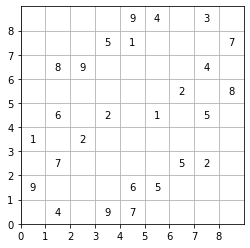

In [8]:
instance = instance1
display_sudoku(instance)

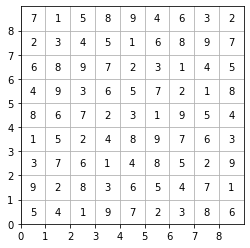

CPU times: user 536 ms, sys: 36.5 ms, total: 573 ms
Wall time: 574 ms


In [9]:
%%time
display_sudoku(sudoku_smt(instance))

## Scheduling

In [10]:
def max_z3(vars):
    max = vars[0]
    for v in vars[1:]:
        max = If(v > max, v, max)
    return max

def schedule(jobs):
    # Variables
    t = []
    for i, job in enumerate(jobs):
        t.append([])
        for j, _ in enumerate(job):
            t[i].append(Int(f"t{i}_{j}"))

    # Solver
    opt = Optimize()

    # Starting time of the task >= 0
    for job in t:
        for start_time in job:
            opt.add(start_time >= 0)

    # Precedence among the successive tasks of each job
    for i, job in enumerate(t):
        for j, (prev, succ) in enumerate(zip(job[:-1], job[1:])):
            opt.add(prev + jobs[i][j][1] <= succ)

    # Machines can only execute one task at a time
    machine_ctrs = {}
    for job in jobs:
        for task in job:
            machine_ctrs[task[0]] = []

    all_tasks = [task for i, job in enumerate(jobs) for task in zip(t[i], job)]
    for (t1, task1), (t2, task2) in combinations(all_tasks, 2):
        if task1[0] == task2[0]:
            machine_ctrs[task1[0]].append(Or(t1 + task1[1] <= t2, t2 + task2[1] <= t1))

    for ctrs_list in machine_ctrs.values():
        opt.add(And(ctrs_list))

    # Objective
    last_tasks = [start_list[-1] + job[-1][1] for job, start_list in zip(jobs, t)]
    makespan = Int('makespan')
    opt.add(makespan <= sum([task[1] for job in jobs for task in job])) # upper bound
    objective = makespan == max_z3(last_tasks)
    opt.add(objective)
    opt.minimize(makespan)

    opt.check()
    m = opt.model()
    sol = []
    for i, job in enumerate(jobs):
        for j, task in enumerate(job):
            start_time = int(m.evaluate(t[i][j]).as_string())
            sol.append({
                'job': i,
                'machine': task[0],
                'duration': task[1],
                'start': start_time,
                'finish': start_time + task[1]
            })
    return sol

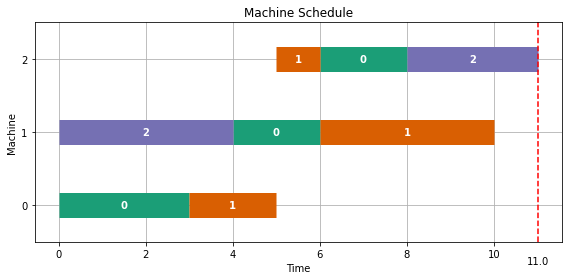

In [11]:
j0 = [(0,3), (1,2), (2,2)]
j1 = [(0,2), (2,1), (1,4)]
j2 = [(1,4), (2,3)]

display_scheduling(schedule([j0, j1, j2]))